# Loading the data

In [7]:
import numpy as np
import pandas as pd
from google.colab import drive

# Step 1: Mount the drive
drive.mount('/content/drive')

# Step 2: Define the path (Replace 'your_file.csv' with your actual filename)
# Note: 'MyDrive' is case-sensitive!
path_prices = "/content/drive/My Drive/2026_Investment_Portfolios_Derby/prices.csv"
path_returns = "/content/drive/My Drive/2026_Investment_Portfolios_Derby/returns.csv"

# Step 3: Read the CSV
prices = pd.read_csv(path_prices, index_col=0, parse_dates=True)
returns = pd.read_csv(path_returns, index_col=0, parse_dates=True)

# Show the first few rows
print(prices.head())
print(returns.tail())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
            ARGT  BTC-USD  DBMF  EMGF  ETH-USD  GLTR  IQLT  QUAL    VOO    VT
Date                                                                         
2019-05-08 25.20 5,982.46 16.52 33.17   170.95 62.75 24.83 81.74 237.85 64.19
2019-05-09 25.38 6,174.53 16.53 32.64   170.29 62.66 24.62 81.48 237.12 63.82
2019-05-10 25.40 6,378.85 16.54 32.70   173.14 63.11 24.79 81.85 238.23 64.13
2019-05-13 24.73 7,814.92 16.41 31.59   196.85 63.25 24.33 79.86 232.39 62.52
2019-05-14 25.07 7,994.42 16.51 31.96   217.15 63.30 24.57 80.49 234.40 63.17
            ARGT  BTC-USD  DBMF  EMGF  ETH-USD  GLTR  IQLT  QUAL   VOO    VT
Date                                                                        
2025-12-24  0.00     0.00 -0.00  0.00    -0.01 -0.00  0.00  0.00  0.00  0.00
2025-12-26  0.01    -0.00  0.01  0.01    -0.01  0.04  0.00  0.00  0.00  0.00
2025-12-29 -0.01 

# Prices and returns for Gut Feeling Portfolio (GF)

In [8]:
# ARGT = 12%, BTC-USD = 11%, DBMF = 10%, EMGF = 23%, ETH-USD = 5%, GLTR = 10%, IQLT = 13%, QUAL = 16%, VOO = 0%, VT = 0%
GF_weights = np.array([0.12, 0.11, 0.10,0.23, 0.05, 0.10, 0.13, 0.16, 0.00, 0.00])

# Computing Prices
gf_prices = prices.dot(GF_weights)
gf_prices.name = 'GF'
prices_2 = pd.concat([prices, gf_prices], axis=1)
print(prices_2.isnull().sum())
print(prices_2.tail())

# Computing Returns
gf_returns = returns.dot(GF_weights)
gf_returns.name = 'GF'
returns_2 = pd.concat([returns, gf_returns], axis=1)
print(returns_2.isnull().sum())
print(returns_2.tail())


ARGT       0
BTC-USD    0
DBMF       0
EMGF       0
ETH-USD    0
GLTR       0
IQLT       0
QUAL       0
VOO        0
VT         0
GF         0
dtype: int64
            ARGT   BTC-USD  DBMF  EMGF  ETH-USD   GLTR  IQLT   QUAL    VOO     VT       GF
Date                                                                                      
2025-12-24 91.48 87,611.96 28.27 57.46 2,945.59 212.80 45.72 200.99 634.78 142.36 9,871.00
2025-12-26 92.17 87,301.43 28.45 57.92 2,925.75 222.35 45.80 201.03 634.84 142.50 9,837.02
2025-12-29 91.68 87,138.14 28.11 57.88 2,934.54 208.96 45.61 200.50 632.60 142.01 9,817.95
2025-12-30 91.46 88,430.13 28.14 57.98 2,971.42 212.25 45.68 200.10 631.72 141.98 9,962.19
2025-12-31 91.41 87,508.83 28.06 57.85 2,967.04 205.60 45.45 198.62 627.13 141.06 9,859.65
ARGT       0
BTC-USD    0
DBMF       0
EMGF       0
ETH-USD    0
GLTR       0
IQLT       0
QUAL       0
VOO        0
VT         0
GF         0
dtype: int64
            ARGT  BTC-USD  DBMF  EMGF  ETH-USD  GLT

# Portfolio Metrics

In [9]:
# --- 1. CONFIGURATION ---
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)  # Ensures no column skipping
pd.set_option('display.width', 1000)        # Prevents line breaks
TRADING_DAYS = 252
rf_rate = 0.035

# --- 2. DATA PROCESSING ---
#returns = np.log(data / data.shift(1)).dropna() --- Already computed

def get_asset_metrics(ticker):
    series = returns_2[ticker]
    prices = prices_2[ticker]

    # Benchmark declaration "VT"
    benchmark_returns = returns_2['VT']
    benchmark_returns_annual = benchmark_returns.mean() * TRADING_DAYS
    benchmark_var = benchmark_returns.var()

    # Performance & Volatility
    ann_ret = series.mean() * TRADING_DAYS
    ann_vol = series.std() * np.sqrt(TRADING_DAYS)

    # Sharpe Ratio in Basis Points (bps) - Fixed calculation
    sharpe_bps = ((ann_ret - rf_rate)/ ann_vol) * 100

    # Information Ratio
    active_return = series - benchmark_returns
    ir = (active_return.mean() / active_return.std()) * np.sqrt(252)

    # --- BETA CALCULATION (Relative to VT) ---
    covariance = series.cov(benchmark_returns)
    beta = covariance / benchmark_var

    # --- CAPM Return (Relative to VT) ---
    capm_return = rf_rate + beta * (benchmark_returns_annual - rf_rate)
    excess_return = ann_ret - capm_return

    # --- DETAILED DRAWDOWN ANALYSIS ---
    roll_max = prices.cummax()
    drawdowns = (prices - roll_max) / roll_max
    max_dd = drawdowns.min()

    # Key Dates
    trough_date = drawdowns.idxmin()
    peak_date = prices[:trough_date].idxmax()

    # Phase 1: Contraction (Peak to Trough)
    days_falling = (trough_date - peak_date).days

    # Phase 2: Recovery (Trough to previous Peak)
    post_trough_prices = prices[trough_date:]
    recovery_series = post_trough_prices[post_trough_prices >= prices[peak_date]]

    if not recovery_series.empty:
        recovery_date = recovery_series.index[0]
        days_recovering = (recovery_date - trough_date).days
        recovery_status = recovery_date.date()
    else:
        recovery_status = "Ongoing"
        days_recovering = (prices.index[-1] - trough_date).days

# --- NON-PARAMETRIC RISK (Historical Simulation - 1 Day) ---
    def calc_hist_risk(series, confidence_level):
        # We look for the alpha percentile (e.g., 1% or 5%)
        alpha = 1 - confidence_level

        # VaR: The empirical quantile
        # We report it as a positive magnitude of loss
        var_1d = -np.percentile(series, alpha * 100)

        # CVaR: The average of losses exceeding the VaR
        tail_losses = series[series <= -var_1d]
        cvar_1d = -tail_losses.mean()

        return var_1d, cvar_1d

    # Calculate 1-Day Historical Metrics
    v95_1d, cv95_1d = calc_hist_risk(series, 0.95)
    v99_1d, cv99_1d = calc_hist_risk(series, 0.99)

    return {
        'Ticker': ticker,
        'Ann_Return %': ann_ret * 100,
        'CAPM_Return %': capm_return * 100,
        'CAPM_Execess_R %': excess_return * 100,
        'Ann_Vol %': ann_vol * 100,
        'IR_bps': ir * 100,
        'Sharpe_bps': sharpe_bps,
        'Beta_bps': beta * 100,
        'Max_DD %': max_dd * 100,
        'Days_Fall': days_falling,
        'Days_Recov': days_recovering,
        'Peak_Date': peak_date.date(),
        'Trough_Date': trough_date.date(),
        'Recov_Date': recovery_status,
        'VaR_95 %': v95_1d * 100,
        'CVaR_95 %': cv95_1d * 100,
        'VaR_99 %': v99_1d * 100,
        'CVaR_99 %': cv99_1d * 100
    }

# --- 3. EXECUTION ---
metrics_results = [get_asset_metrics(t) for t in prices_2.columns]
df_report = pd.DataFrame(metrics_results).set_index('Ticker')

# Grouped Columns for horizontal consistency
perf_risk_cols = ['Ann_Return %', 'CAPM_Return %', 'CAPM_Execess_R %', 'Ann_Vol %', 'IR_bps', 'Sharpe_bps', 'Beta_bps', 'VaR_95 %', 'CVaR_95 %', 'VaR_99 %', 'CVaR_99 %']
drawdown_cols = ['Max_DD %', 'Days_Fall', 'Days_Recov', 'Peak_Date', 'Trough_Date', 'Recov_Date']

# --- 4. PROFESSIONAL CONSOLE OUTPUT ---
print("\n" + "="*130)
print("ASSET REPORT: PERFORMANCE, RISK & DRAWDOWN ANALYSIS")
print("="*130)

print("\n SECTION 1: PERFORMANCE & TAIL RISK PROFILE")
print("-" * 130)
print(df_report[perf_risk_cols])

print("\n SECTION 2: DRAWDOWN DYNAMICS (CONTRACTION & RECOVERY)")
print("-" * 130)
print(df_report[drawdown_cols])

print("\n SECTION 3: CROSS-ASSET CORRELATION MATRIX (%)")
print("-" * 130)
print(returns_2.corr() * 100)

print("\n" + "="*130)
print(f"Report Period: {returns_2.index[0].date()} to {returns_2.index[-1].date()} | Trading Days: {TRADING_DAYS}")
print("="*130)


ASSET REPORT: PERFORMANCE, RISK & DRAWDOWN ANALYSIS

 SECTION 1: PERFORMANCE & TAIL RISK PROFILE
----------------------------------------------------------------------------------------------------------------------------------
         Ann_Return %  CAPM_Return %  CAPM_Execess_R %  Ann_Vol %  IR_bps  Sharpe_bps  Beta_bps  VaR_95 %  CVaR_95 %  VaR_99 %  CVaR_99 %
Ticker                                                                                                                                   
ARGT            19.42          13.28              6.14      34.84   28.15       45.70    116.90      3.13       5.00      5.39       9.45
BTC-USD         40.44          13.38             27.05      63.97   47.69       57.74    118.13      5.77       9.36     11.29      16.79
DBMF             7.98           4.52              3.46      12.28  -18.74       36.50     12.16      1.31       1.91      2.24       3.13
EMGF             8.38          10.74             -2.35      19.80  -31.41       2

/tmp/ipython-input-4125165265.py:29: RuntimeWarning: invalid value encountered in scalar divide
  ir = (active_return.mean() / active_return.std()) * np.sqrt(252)


/tmp/ipython-input-4142599151.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta1, alpha1 = model1.params[1], model1.params[0]


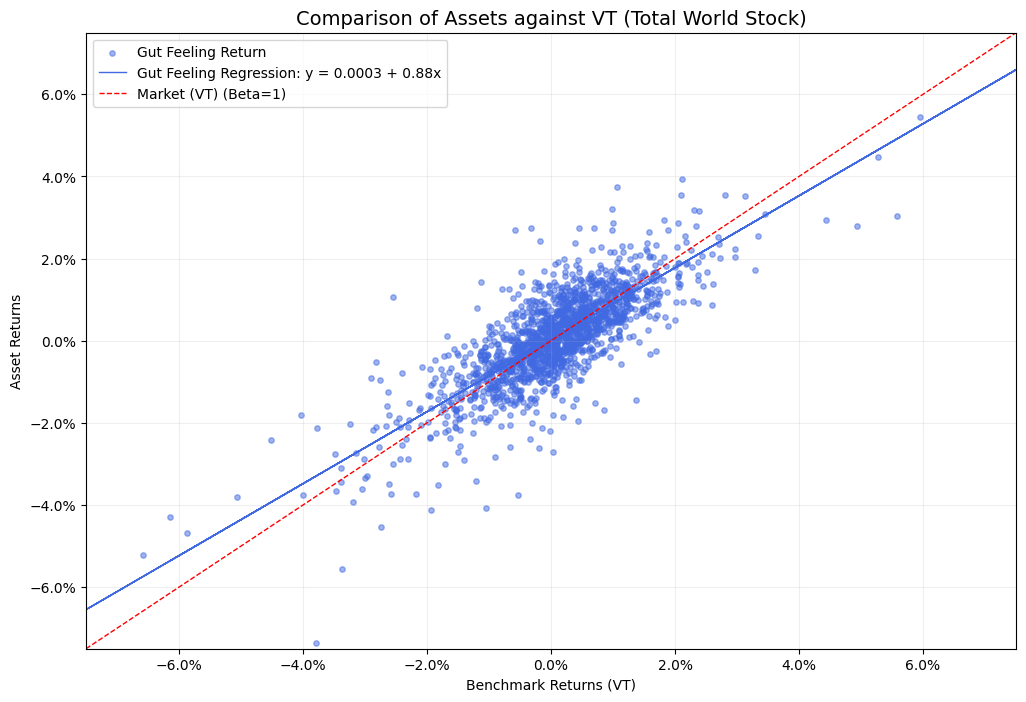

                            OLS Regression Results                            
Dep. Variable:                     GF   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     3547.
Date:                Thu, 08 Jan 2026   Prob (F-statistic):               0.00
Time:                        01:26:04   Log-Likelihood:                 5860.0
No. Observations:                1672   AIC:                        -1.172e+04
Df Residuals:                    1670   BIC:                        -1.171e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.420      0.1

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 1. Define the Benchmark (X) and the two assets (y1, y2)
X = returns_2['VT']
y1 = returns_2['GF']

# 2. Prepare X (add constant for intercept)
X_const = sm.add_constant(X)

# 3. Run regressions
model1 = sm.OLS(y1, X_const, missing='drop').fit()

# 4. Extract Beta and Alpha
beta1, alpha1 = model1.params[1], model1.params[0]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# --- 3. DIBUJO DE DATOS ---
# (Aquí puedes seguir usando plt o ax, pero es mejor usar 'ax' por consistencia)
ax.scatter(X, y1, color='royalblue', s=15, alpha=0.5, label='Gut Feeling Return')
ax.plot(X, alpha1 + beta1 * X, color='royalblue', alpha=1, lw=1, label=f'Gut Feeling Regression: y = {alpha1:.4f} + {beta1:.2f}x')
ax.axline((0, 0), slope=1, color='red', linewidth=1, linestyle='--', label='Market (VT) (Beta=1)')

# --- 4. FORMATO Y LÍMITES  ---
# Ahora que 'ax' existe, estas líneas ya no darán error:
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Posionamiento del grafico
ax.set_xlim([-0.075, 0.075])
ax.set_ylim([-0.075, 0.075])

# CAMBIA LOS PLT. POR AX.SET_ PARA LOS TÍTULOS:
ax.set_title(f'Comparison of Assets against {X.name} (Total World Stock)', fontsize=14)
ax.set_xlabel(f'Benchmark Returns ({X.name})')
ax.set_ylabel('Asset Returns')

ax.legend(frameon=True)
ax.grid(True, alpha=0.2)

plt.show()

# Optional: see the full statistical summary
print(model1.summary())